In the previous post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce hierarchical modeling, and the use of varying effects as a means to build more robust models.

Hierarchical modeling refers to the fact that the inference is conducted on multiple levels. The hierarchical structure is based on the notion that the data can be grouped into different clusters. The coefficients relevant to each cluster will have their own priors, drawn from a common set of *hyper priors*.

In [46]:
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import pickle
from IPython.core.display import display, HTML

In [47]:
# Setting graphics...
% matplotlib inline
rc_ = {}
rc_['xtick.labelsize'] = 16
rc_['ytick.labelsize'] = 16
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 16
rc_['font.size'] = 16
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18
display(HTML("<style>.container {width: 90% !important}</style>"))
pl.style.use('bmh')

Below, I load training and testing datasets prepared and pickled earlier, in the previous post:

In [13]:
with open('./pickleJar/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [14]:
df_train = datasets['swf']['train']
df_test = datasets['swf']['test']
del datasets

I'll refer to the test set at the very end. The training data set features a column titled '*maxBlueId*':

In [15]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a
0,1565,-0.267867,rrs510,1.581950
1,1566,-0.220457,rrs510,1.544192
2,1567,-0.268537,rrs510,1.429914
3,1568,-0.279976,rrs510,1.680879
4,1559,-0.167733,rrs510,1.371991


*maxBlueId* is a categorical variable that indicates which 'blue' band was used for the blue-to-green ratio; 443, 490, 510. I will use this as a clustering mechanism, and examine whether there is much difference between groups vis-a-vis chlorophyll. A first step is to repeat our previous data exploration step, with the additional maxBlueId information incorporated into the graph:

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


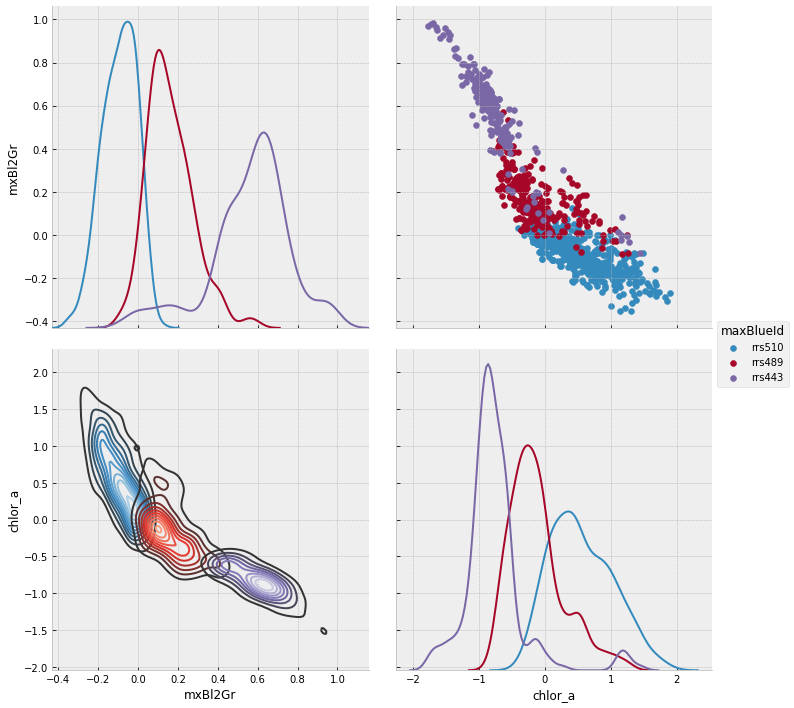

In [45]:
vars_ = ['mxBl2Gr', 'chlor_a']
g  = sb.PairGrid(df_train, vars=['mxBl2Gr', 'chlor_a'],size=5, diag_sharey=False,
                hue='maxBlueId',
                hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]})
gupper = g.map_upper(pl.scatter)
gdiag = g.map_diag(sb.kdeplot)
glower = g.map_lower(sb.kdeplot)
g.add_legend();

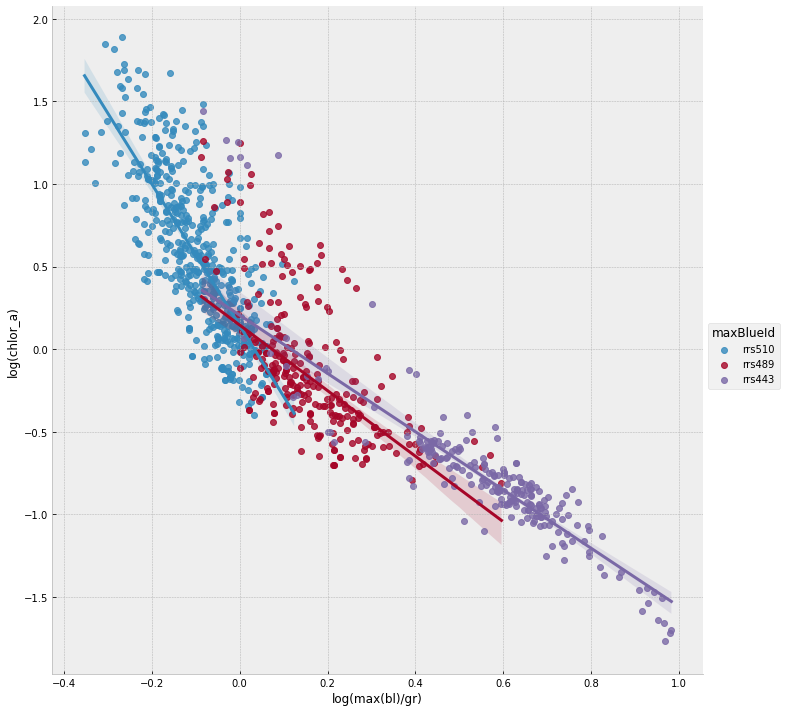

In [63]:
g = sb.lmplot(x="mxBl2Gr", y="chlor_a", hue="maxBlueId", truncate=True, size=10, data=df_train, robust=True)

# Use more informative axis labels than are provided by default
g.set_axis_labels("log(max(bl)/gr)", "log(chlor_a)")

While there is some overlap between clusters, these nevertheless seem well defined, and the progression of lower chlorophyll to higher chlorophyll follows a predictable rrs443$\rightarrow$rrs490$\rightarrow$rrs-510 progression. This suggests a couple of lines of inquiry for this post:
* Whether cluster-specific intercepts are significantly different
* Whether cluster-specific slopes are significantly different
* Whether a high order polynomial regression like OC4 is still justifiable, given the relatively simpler relationship (fewer inflexion points of $frac{blue}{green}$ to $chlor_a$ observed within each cluster

In order to index into each cluster, I have to create a numerical category column of *maxBlueId*, 0-indexed:

In [65]:
df_train['max_blue_id_cat'] = df_train.maxBlueId.astype('category').cat.codes
df_train.tail()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat
4454,6901,-0.111150,rrs510,0.665378,2
4455,6902,-0.053143,rrs489,0.471287,1
4456,6914,0.153314,rrs489,-0.021756,1
4457,6903,-0.097079,rrs510,0.657274,2
4458,6915,-0.176237,rrs510,0.763947,2


Now we can implement a first model, in the image of OC4 (see [previous post]()). I will use weakly regularizing priors. Note also that to save time, I precompute the polynomial imputs:

In [66]:
df_train['mxBl2Gr_2'] = df_train.mxBl2Gr**2
df_train['mxBl2Gr_3'] = df_train.mxBl2Gr**3
df_train['mxBl2Gr_4'] = df_train.mxBl2Gr**4

In [68]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat,mxBl2Gr_2,mxBl2Gr_3,mxBl2Gr_4
0,1565,-0.267867,rrs510,1.581950,2,0.071753,-0.019220,0.005148
1,1566,-0.220457,rrs510,1.544192,2,0.048601,-0.010714,0.002362
2,1567,-0.268537,rrs510,1.429914,2,0.072112,-0.019365,0.005200
3,1568,-0.279976,rrs510,1.680879,2,0.078386,-0.021946,0.006144
4,1559,-0.167733,rrs510,1.371991,2,0.028134,-0.004719,0.000792


In [71]:
df_train.max_blue_id_cat.unique().size
x_input = df_train.as_matrix(columns=['mxBl2Gr%s' %i for i in ['', '_2','_3','_4']])

In [73]:
x_input[:3]

array([[-0.26786697,  0.07175271, -0.01922018,  0.00514845],
       [-0.22045677,  0.04860119, -0.01071446,  0.00236208],
       [-0.26853699,  0.07211211, -0.01936477,  0.00520016]])

In [ ]:
n_clusters= df_train.max_blue_id_cat.unique().size
with pm.Model() as m1g:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1, shape=[n_clusters, 4])